# Light Ale, Big Fail: What Beer Reviewers Hate the Most

In [1]:
import langid
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sn

from src.utils import tqdm
from src.data_loading import iter_reviews, load_beers_breweries_users, data_load
from src.data_processing import add_review_columns, build_corpus
from src.text_processing import get_stop_words, get_word_counts, get_tfidf_scores, get_top_attributes, Lemmatizer, Stemmer
from src.text_processing import top_attributes_by
from src.text_processing import classify_beer_attributes
from src.plots import plot_review_count_comparison, plot_location_comparison

In [2]:
import nltk

nltk.download("all", quiet=True)

True

Download `RateBeer` and `BeerAdvocate` [here](https://drive.google.com/drive/folders/1Wz6D2FM25ydFw_-41I9uTwG9uNsN4TCF?usp=sharing), download `RateBeer_processed` [here](https://drive.google.com/drive/folders/1s9_0rZTotFhhWg2Y9h3B41Vmh8tTp2lj?usp=sharing) and unzip both in the `data` folder.

## Introduction and motivation

#### Dataset choice

We first compare key the RateBeer and BeerAdvocate datasets on key aspects before choosing which one to use.

In [3]:
ba_users = pd.read_csv("./data/BeerAdvocate/users.csv")
ba_breweries = pd.read_csv("./data/BeerAdvocate/breweries.csv")
ba_beers = pd.read_csv("./data/BeerAdvocate/beers.csv")
ba_beers["beer_id"] = ba_beers["beer_id"].astype(str)

rb_users = pd.read_csv("./data/RateBeer/users.csv")
rb_breweries = pd.read_csv("./data/RateBeer/breweries.csv")
rb_beers = pd.read_csv("./data/RateBeer/beers.csv")
rb_beers["beer_id"] = rb_beers["beer_id"].astype(str)

In [4]:
ba_beers = add_review_columns("./data/BeerAdvocate/reviews.txt", ba_beers, by="beer_id")
rb_beers = add_review_columns("./data/RateBeer/reviews.txt", rb_beers, by="beer_id")

100%|█████████████████████████████████████████████████| 7122074/7122074 [00:36<00:00, 196697.23it/s]


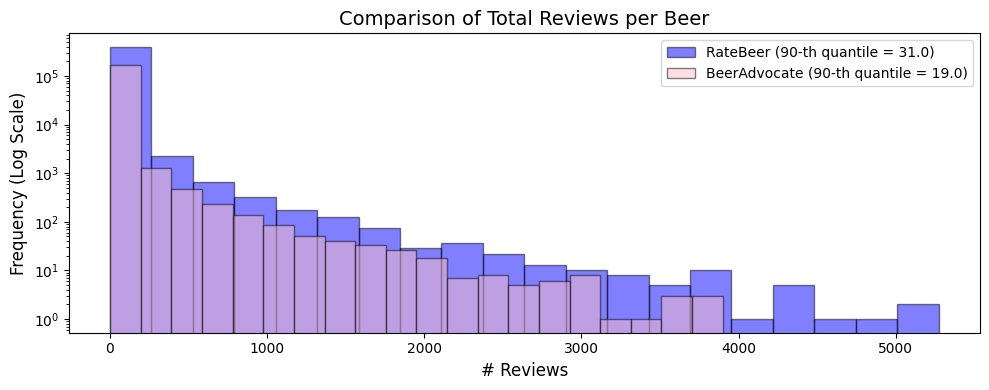

In [5]:
plot_review_count_comparison(rb_beers, ba_beers)
plt.show()

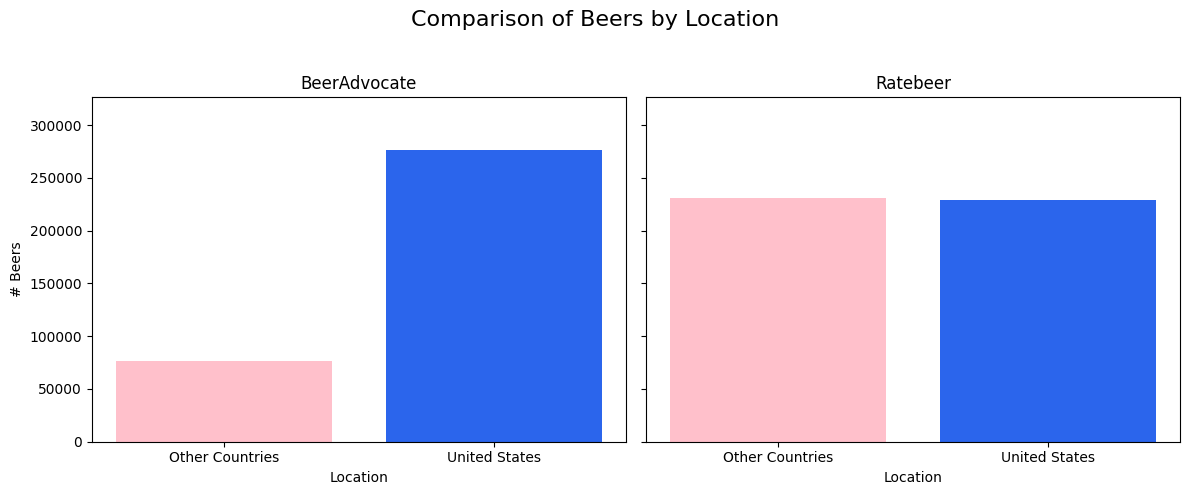

In [6]:
plot_location_comparison(rb_breweries, ba_breweries)
plt.show()

We analyze beers, not users, so in a nutshell we need many beers with many reviews. Also, our idea is to extract information from textual reviews, so the numerical ratings themselves are unimportant. For this reason, we care about
- The number of textual reviews : RateBeer has 7M, versus BeerAdvocate's 2.5M.
- The distribution of the number of reviews by beer : RateBeer has more beers with many reviews, compared to BeerAdvocate. See the "Comparison of Total Reviews per Beer" plot.
- The geographic diversity of the beers reviewed (for analysis by location) : RateBeer beers are much more international, while a majority of BeerAdvocate beers are from the USA, which makes analysis by location not very significant statistically for countries outside the USA. (Note that RateBeer users are also more international than BeerAdvocate users, but this is not the topic of our analysis.)
For the above reasons, we choose to work on RateBeer.

We choose not to work on a combination of both datasets, because
- There is overlap between the two datasets (some beers appear in both), but matching them precisely is difficult. The beer and brewery names differ slightly in the datasets, so we would need to rely on text similarity. The provided matched data only includes beers that are clearly the same (based on similar names and breweries with no ambiguity, see [When Sheep Shop: Measuring Herding Effects in Product Ratings with Natural Experiments](https://dlab.epfl.ch/people/west/pub/Lederrey-West_WWW-18.pdf)). While this ensures accuracy, it significantly reduces the amount of data to avoid false matches. If we merged the datasets this way, we’d lose a lot of data due to these ambiguities. Alternatively, we could combine the datasets without worrying about duplicate beers, but this would not be rigorous from a data analysis standpoint.
- Our analysis of RateBeer already pushes the limits of the hardware we have. For example, running text analysis methods takes a long time: a few hours for attribute and criticism extraction using tf-idf, a few hours for criticism classification, and overnight for emotion analysis. Adding more data would likely increase computation time and memory requirements beyond what we can handle.
- Combining the two datasets would skew the geographic diversity since BeerAdvocate’s beers are mostly from the USA. This isn’t necessarily a problem, but we already have plenty of data for beers from the USA. Instead, data from underrepresented regions, like Eastern Europe, where reviews are currently lacking, would be more valuable and may be worth the extra effort.

## Data pre-processing

#### Milestone 2 processing

The first step is to process the beers, breweries and users data as in milestone 2.

In [8]:
raw_directory = "./data/RateBeer/"
processed_directory = "./data/RateBeer_processed/"

if os.path.exists(processed_directory):
    beers = pd.read_csv(processed_directory + "beers.csv")
    breweries = pd.read_csv(processed_directory + "breweries.csv")
    users = pd.read_csv(processed_directory + "users.csv")

else:
    os.makedirs(processed_directory)

    beers, breweries, users = load_beers_breweries_users(raw_directory)
    beers = add_review_columns(raw_directory + "reviews.txt", beers, by="beer_id")
    users = add_review_columns(raw_directory + "reviews.txt", users, by="user_id")
    users = users[~users.duplicated(subset='user_id', keep=False)]

    drop_columns = [
        "overall_score", "style_score", "zscore", "nbr_matched_valid_ratings", "avg_matched_valid_ratings"
    ]
    beers = beers.drop(columns=drop_columns)

    #beers["beer_id"] = beers["beer_id"].astype("string")

    beers.to_csv(processed_directory + "beers.csv", index=False)
    breweries.to_csv(processed_directory + "breweries.csv", index=False)
    users.to_csv(processed_directory + "users.csv", index=False)

The filtered data contains 400k different beers, 93 beer styles, and 70k users from 217 countries/territories.

In [9]:
unique_beers = len(beers["beer_id"].unique())
unique_styles = len(beers["style"].unique())
unique_users = len(users["user_id"].unique())
unique_countries = len(breweries[~breweries["location"].str.startswith("United States")]["location"].unique()) + 1
unique_beers, unique_styles, unique_users, unique_countries

(396690, 93, 70112, 217)

#### Reviews language and threshold

To ensure robust analysis, we choose to focus only on english language reviews, which make up 95% of the reviews in our data. Additionally, we select beers with 300 reviews at least, to be sure that we have enough textual data for further analysis.

In [10]:
threshold = 300
reviews_csv_path = processed_directory + "popular_beers_reviews.csv"

if os.path.exists(reviews_csv_path):
    reviews = pd.read_csv(reviews_csv_path)

else:
    popular_beers = beers[beers["review_count"] > threshold]
    popular_beers_id = list(popular_beers["beer_id"])
    
    reviews = [r for r in iter_reviews(raw_directory + "reviews.txt", do_cast=True)
               if r["beer_id"] in popular_beers_id]

    # non-english reviews have encoding issues and unique words that may bias our analysis (eg tf-idf)
    for review in tqdm(reviews):
        language, _ = langid.classify(review["text"])
        review["language"] = language

    reviews = pd.DataFrame(reviews)
    reviews.to_csv(reviews_csv_path, index=False)

non_english = len(reviews[reviews["language"] != "en"])
print(f"{100 * (non_english / len(reviews)):.1f}% non-english reviews")

beers_count = len(reviews["beer_id"].value_counts())
print(f"{beers_count} beers with more than {threshold} reviews ({len(reviews)} reviews in total)")

5.5% non-english reviews
3185 beers with more than 300 reviews (2271818 reviews in total)


In [11]:
reviews = reviews[reviews["language"] == "en"]

## Extracting features from beers

#### Finding the experts

Some reviews seem to be written by people with a lot of experience when it comes to reviewing beers. We seize the opportunity to give a bigger importance to such quality text, which makes the result of our analysis more precise (because the vocabulary used by the experts is precise).

Here we select some reviews as an example.

In [7]:
# example beer reviews for canadian beer "Dieu du Ciel Aphrodisiaque"
levels = ["Beginner", "Expert  ", "Expert  "]
expert_vs_beginner_reviews = reviews.loc[[29575, 29428, 29429]]["text"].tolist()

for level, text in zip(levels, expert_vs_beginner_reviews):
    print(f"{level} -> \"{text}\"\n")

Beginner -> "Nice beer. Love the color and the scent. Very tasty. Goes down easily, very easily.---Rated via Beer Buddy for iPhone "

Expert   -> "Strong chocolate, cocoa, vanilla, malt, a little dark fruit aroma. Tastes similar. Very velvety, smooth, roasted malt and cocoa chocolate.  "

Expert   -> "Wow, this is excellent! Pours a thick black with a tan head. Nose is toasted malt, vanilla, cocoa. Taste is more of these flavours, solid bitterness from the roasted malt and dark chocolate. Perfectly balanced.  "



This leads us to the introduction of "expert" users, whose contributions are given a bigger weight as their experience is extremely valuable. We select the experts to be those that are in the top 5% of users with the most reviews.

In [12]:
expert_threshold = users["review_count"].quantile(0.95)
experts = users[users["review_count"] > expert_threshold]["user_id"].tolist()
expert_threshold

310.0

#### using tf-idf

To extract attributes, we build a corpus by concatenating each beers reviews, giving expert reviewers' reviews five-fold the importance, hoping to extract strong descriptors for our beers. We lemmatize the words, and ignore words that are too frequent in the english language or in our corpus. Then we compute tf-idf scores for each word, and take the best 100 words for each beer.

In [15]:
processed_beers_csv = processed_directory + "popular_beers_with_attributes.csv"

if os.path.exists(processed_beers_csv):
    beers = pd.read_csv(processed_beers_csv)

else:
    corpus, corpus_beers = build_corpus(reviews, expert_ids=experts, expert_weight=5)

    tokenizer = Lemmatizer

    stop_words = get_stop_words(corpus, tokenizer=tokenizer)
    word_counts = get_word_counts(corpus, corpus_beers, tokenizer=tokenizer, stop_words=stop_words, min_df=0.02)

    tfidf_scores = get_tfidf_scores(word_counts)
    top_attributes = get_top_attributes(tfidf_scores, top_attributes=100) # can always take only the top 50 later

    beers = beers.merge(top_attributes.reset_index(), on="beer_name")

#### using LDA

We tried using LDA to see if we could extract topics, and if there was any interesting pattern, but the results were underwhelming and we abandoned this idea.

In [ ]:
#data = pd.read_pickle("./data/review_with_emotions.pkl")
# lda_by_beers(data, 7)
data = pd.read_pickle("./data/results_lda.pkl")

In [ ]:
model_lda = models.LdaModel.load("./data/LDA_model.pkl")
for x in model_lda.print_topics(num_topics=7, num_words=5):
    print("Topic", x[0], ":", x[1])

Topic 0 : 0.036*"hazy" + 0.022*"orange" + 0.021*"golden" + 0.019*"yellow" + 0.019*"yeast"
Topic 1 : 0.048*"sour" + 0.032*"tart" + 0.020*"bottle" + 0.018*"red" + 0.015*"fruit"
Topic 2 : 0.026*"citrus" + 0.025*"hop" + 0.024*"orange" + 0.022*"hops" + 0.021*"hoppy"
Topic 3 : 0.047*"roasted" + 0.043*"black" + 0.042*"chocolate" + 0.039*"brown" + 0.029*"coffee"
Topic 4 : 0.032*"golden" + 0.022*"bottle" + 0.021*"pale" + 0.020*"malty" + 0.016*"yellow"
Topic 5 : 0.043*"brown" + 0.033*"caramel" + 0.028*"amber" + 0.023*"malty" + 0.022*"bottle"
Topic 6 : 0.019*"like" + 0.013*"one" + 0.012*"little" + 0.010*"much" + 0.009*"color"


## Extracting negative features

#### Using experts and ratings

Our method for extracting negative features works similarly as for extracting characteristics. However, the first step is to separate the reviews into low-rated and high-rated. The low-rated reviews are the 10% worst rated reviews for each beer, and the other are considered high-rated. We call this the "quantile split" method. We now compute tf-idf scores separately for the positive corpus and the negative corpus. Finally, to select complaints and criticism, for each word we subtract the score on the negative corpus by the score on the positive corpus, selecting the best 100 words that are specific to the negative reviews and not the positive ones.

In [16]:
# don't reload processed beers data if the file exists, as we have loaded it in the attribute extraction part already

if not os.path.exists(processed_beers_csv):
    pos_corpus, neg_corpus, beer_names = build_corpus(reviews, expert_ids=experts, expert_weight=5, quantile_split=10)

    tokenizer = Lemmatizer
    stop_words = get_stop_words([pos_doc + neg_doc for pos_doc, neg_doc in zip(pos_corpus, neg_corpus)], tokenizer=tokenizer)

    neg_counts = get_word_counts(neg_corpus, beer_names, tokenizer=tokenizer, stop_words=stop_words, min_df=0.02)
    pos_counts = get_word_counts(pos_corpus, beer_names, tokenizer=tokenizer, stop_words=stop_words, vocabulary=neg_counts.columns)
    
    scores = get_tfidf_scores(neg_counts) - get_tfidf_scores(pos_counts)
    top_criticisms = get_top_attributes(scores, column_prefix="crit_", top_attributes=100)

    beers = beers.merge(top_criticisms.reset_index(), on="beer_name")

#### Using emotion analysis

We use the emotion analysis model [Emotion English DistilRoBERTa-base](https://huggingface.co/j-hartmann/emotion-english-distilroberta-base) specifically on high-rated reviews, hoping to extract more subtle or mixed feedback. The model outputs a score for each of the following emotions : anger, disgust, fear, joy, neutral, sadness, surprise.

In [ ]:
# use this link to download graphs and all the needed dataframes and graphs: 
# https://drive.google.com/drive/folders/1wggLpvzeNB2IIY3vebOUGbSt7SwRFiQY?usp=drive_link

#nb_reviews = 58824 # about 1M lines 
#path_to_rating = "./data/RateBeer/reviews.txt"
# raw_data = data_load(path_to_rating, "all")
#raw_data = data_load(path_to_rating, nb_reviews)

#english_lines = [ind for ind, rev in enumerate(raw_data["review"]) if langid.classify(rev)[0] == "en"]
#english_data = raw_data.loc[english_lines]

# data = emotion_sentiment(english_data, cuda=True)
# user = pd.read_csv("data/RateBeer/users.csv") # We merge on users.csv to get the location of the users
# data = data.merge(user, on="user_id") 
#data = pd.read_pickle("./data/review_with_emotions.pkl")

Intuitively, "negative" emotions should be more present in low-rated than high-rated reviews, and conversely for "positive" emotions. This is the case here. The most prevalent emotions are disgust, joy and neutral. From now on, we only consider sadness, disgust, joy and neutral.

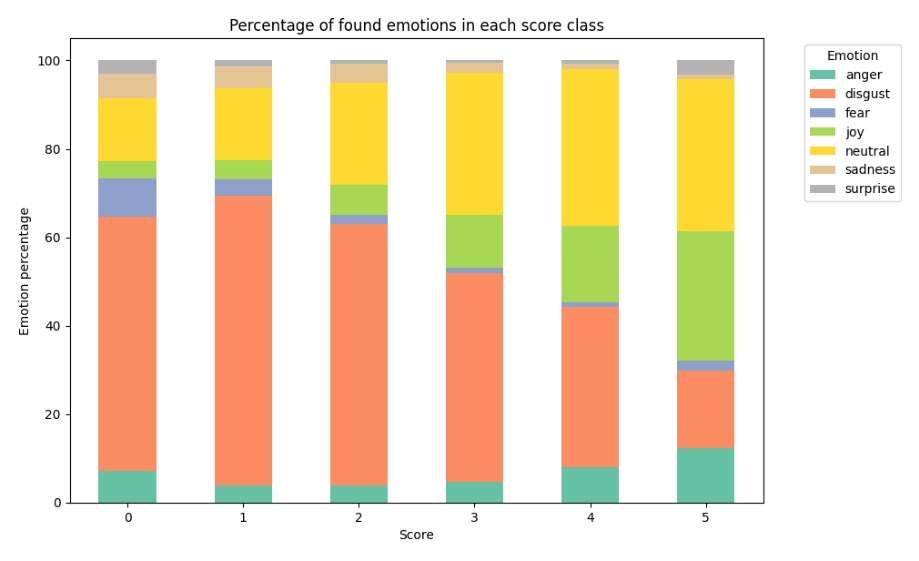

Spearman correlation for emotions by score: 
(if p value < 0.05 we can say that a change in score, introducted a predictable increase or decrease in the percentage for that emotion) 
          Spearman correlation   
anger                 0.600000  
disgust              -0.828571  
fear                 -0.657143  
joy                   1.000000  
neutral               0.942857  
sadness              -1.000000  
surprise              0.028571  



In [16]:
# plot_emotion_by_score_spearman(data)

fig, ax = plt.subplots(figsize=(10, 6))
img = mpimg.imread('graphs/emotions_by_class.png')
ax.imshow(img)
plt.tight_layout()
plt.axis('off')
plt.show()

with open("graphs/spearman_output.out", "r") as f:
    print(f.read())

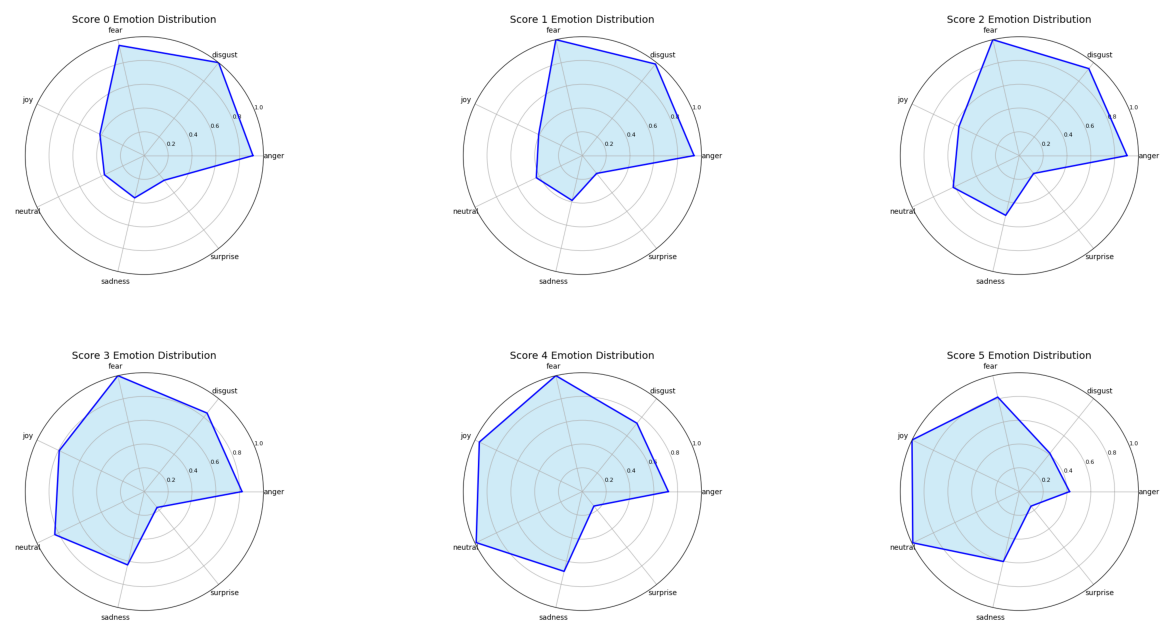

In [ ]:
# data = pd.read_pickle("lda_by_beer/results_lda.pkl")
# plot_score_emotions_distrib(data)

imgs = [mpimg.imread('graphs/radar_graph_emotions_by_score_0.png'),
        mpimg.imread('graphs/radar_graph_emotions_by_score_1.png'), 
        mpimg.imread('graphs/radar_graph_emotions_by_score_2.png'),
        mpimg.imread('graphs/radar_graph_emotions_by_score_3.png'),
        mpimg.imread('graphs/radar_graph_emotions_by_score_4.png'),
        mpimg.imread('graphs/radar_graph_emotions_by_score_5.png'),]
_, axs = plt.subplots(2, 3, figsize=(16, 8))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.axis('off') 
    ax.imshow(img)
plt.show()

This essentially adds an extra step, which is extracting parts of reviews that are particularly negative (disgust, sadness) or positive (joy, neutrality). We call this the "emotion split" method. We then build the positive corpus using the positive parts and negative corpus using the negative parts, and run tf-idf for extracting criticism as explained previously.

The aim here is to extract more subtle or mixed feedback, that the previous method misses because it focuses on the obvious criticism that low-rated reviews provide in a straightforward manner.

In [17]:
# much faster, we focus on the negative and positive parts

if not os.path.exists(processed_beers_csv):
    pos_corpus, neg_corpus, beer_names = build_corpus(reviews, emotion_split=True)

    tokenizer = Lemmatizer
    stop_words = get_stop_words([pos_doc + neg_doc for pos_doc, neg_doc in zip(pos_corpus, neg_corpus)], tokenizer=tokenizer)

    neg_counts = get_word_counts(neg_corpus, beer_names, tokenizer=tokenizer, stop_words=stop_words, min_df=0.02)
    pos_counts = get_word_counts(pos_corpus, beer_names, tokenizer=tokenizer, stop_words=stop_words, vocabulary=neg_counts.columns)

    scores = get_tfidf_scores(neg_counts) - get_tfidf_scores(pos_counts)
    top_criticisms_emotions = get_top_attributes(scores, column_prefix="crit_emot_", top_attributes=100)

    beers = beers.merge(top_criticisms_emotions.reset_index(), on="beer_name")
    beers.to_csv(processed_beers_csv, index=False)

## Following the clues : what drives negativity

#### Analysis of top criticisms by location, beer style, alcohol content

Here we showcase attributes and criticism by example locations and styles.

In [23]:
# beer subsets for visualization
locations = ["Belgium", "Brazil", "Croatia", "England", "Germany", "United States, Kentucky"]
styles = ["American Pale Ale", "American Strong Ale ", "Cream Ale", "Czech Pilsner (Světlý)", "Dunkelweizen", "Fruit Beer", "Imperial Porter"]

Using the 50 strongest attributes, we display the 15 most prevalent attributes by country/region.

In [24]:
top_attributes_by(beers, by="location", top_count=15, column_count=50).loc[locations]

,top_attr_1,top_attr_2,top_attr_3,top_attr_4,top_attr_5,top_attr_6,top_attr_7,top_attr_8,top_attr_9,top_attr_10,top_attr_11,top_attr_12,top_attr_13,top_attr_14,top_attr_15
location,,,,,,,,,,,,,,,
Belgium,belgian,golden,banana,yellow,gold,go,grape,cherry,peach,coriander,pear,berry,reddish,wood,beige
Brazil,corn,go,lager,south,vegetable,yellow,world,wheat,waitrose,unique,tick,thirst,tesco,systembolaget,syrup
Croatia,zagreb,lager,macro,pivo,country,croatia,hot,lcbo,metal,industrial,corny,eastern,euro,european,go
England,english,beige,golden,copper,roast,go,nut,cask,pint,nutty,reddish,chocolate,british,gold,burnt
Germany,go,golden,gold,yellow,wheat,straw,lager,refreshing,banana,beige,roast,wheaty,corn,munich,weizen
"United States, Kentucky",kentucky,go,draft,louisville,barrel,bourbon,age,copper,chocolate,char,burnt,beige,woody,wood,whiskey


Using the 50 strongest criticisms from the "quantile split" method, we display the 15 most prevalent criticisms by country/region.

In [25]:
top_attributes_by(beers, by="location", top_count=15, column_count=50, column_prefix="crit_").loc[locations]

,top_crit_1,top_crit_2,top_crit_3,top_crit_4,top_crit_5,top_crit_6,top_crit_7,top_crit_8,top_crit_9,top_crit_10,top_crit_11,top_crit_12,top_crit_13,top_crit_14,top_crit_15
location,,,,,,,,,,,,,,,
Belgium,alcoholic,artificial,acid,vinegar,yellow,sourish,syrup,blond,juice,weird,cider,belgian,wheat,metal,disappointing
Brazil,woman,waste,vegetable,adjunct,corn,bus,coca,cola,collins,coors,cross,deceive,department,dirty,distributor
Croatia,country,corny,awful,avoid,cardboard,generic,metal,recommend,pointless,plastic,longlasting,grand,hayish,headf,heineken
England,bland,skunk,cask,london,skunky,burnt,black,stale,lager,cardboard,poor,salty,disappointing,metal,stout
Germany,skunky,corn,bland,boring,skunk,yellow,wheaty,wheat,lager,cardboard,bore,disappointing,nasty,metal,stale
"United States, Kentucky",oak,licorice,stout,wow,whiskey,popcorn,seriously,drain,barrel,butter,black,cigarette,leather,lightish,locally


Using the 50 strongest criticisms from both "split" methods, we display the 15 most prevalent criticisms by beer style.

In [26]:
top_attributes_by(beers, by="style", top_count=15, column_count=50, column_prefix=["crit_", "crit_emot_"]).loc[styles]

,top_crit_crit_emot_1,top_crit_crit_emot_2,top_crit_crit_emot_3,top_crit_crit_emot_4,top_crit_crit_emot_5,top_crit_crit_emot_6,top_crit_crit_emot_7,top_crit_crit_emot_8,top_crit_crit_emot_9,top_crit_crit_emot_10,top_crit_crit_emot_11,top_crit_crit_emot_12,top_crit_crit_emot_13,top_crit_crit_emot_14,top_crit_crit_emot_15
style,,,,,,,,,,,,,,,
American Pale Ale,perfume,peel,acid,rough,poor,pint,rocky,peach,pear,pungent,poured,ripe,pours,pine,pilsner
American Strong Ale,roast,plum,prune,rough,powerful,rotten,acid,peel,poor,peach,ruby,prickly,pint,salty,ripe
Cream Ale,perfume,peach,pale,overly,pepper,acid,pear,persistent,place,quality,peel,ripe,rotten,pick,pilsner
Czech Pilsner (Světlý),aroma,corn,bitter,pine,skunky,pale,taste,peach,pilsner,poor,skunk,sourness,smell,pint,perfume
Dunkelweizen,pours,murky,muddy,dark,aroma,color,brown,tan,smell,sour,mouthfeel,bitter,wheaty,nose,sourness
Fruit Beer,perfume,rotten,poor,peach,peel,acid,pours,ruby,puffy,plum,pub,pilsner,prickly,presence,powerful
Imperial Porter,salty,pitch,pours,roasty,roast,pine,ruby,roasted,poor,poured,plum,rough,prune,pungent,ring


Using the 50 strongest criticisms from both "split" methods, we compute the 15 most prevalent criticisms for each beer and display the first 2.

In [27]:
top_attributes_by(beers, by="beer_name", top_count=15, column_count=50, column_prefix=["crit_", "crit_emot_"]).head(2)

,top_crit_crit_emot_1,top_crit_crit_emot_2,top_crit_crit_emot_3,top_crit_crit_emot_4,top_crit_crit_emot_5,top_crit_crit_emot_6,top_crit_crit_emot_7,top_crit_crit_emot_8,top_crit_crit_emot_9,top_crit_crit_emot_10,top_crit_crit_emot_11,top_crit_crit_emot_12,top_crit_crit_emot_13,top_crit_crit_emot_14,top_crit_crit_emot_15
beer_name,,,,,,,,,,,,,,,
1795 Original Czech Lager (Budejovické Pivo),abound,opaque,pee,pear,peach,overwhelms,overpower,overly,open,old,oily,offwhite,number,noteworthy,nastiness
1809 Berliner Style Weisse,citric,zesty,yellow,write,wish,wet,warrant,unappealing,transparent,scent,rice,rbesg,raspberry,puffy,presence


#### Classifying common criticisms in different locations

To better understand the attributes we extract, we classify the extracted features using the [bart-large-mnli](https://huggingface.co/facebook/bart-large-mnli) model into the following categories : appearance, aroma, palate and taste. In particular, we classify criticisms by country, and by beer style. This will allow us create interactive visualizations that allow us to interactively explore what people hate, which is what we set out to do. We decided to create interactive maps for the website because static plots (even maps) make it hard to visualize words and explore.

In [28]:
location_features = top_attributes_by(beers, by="location", top_count=150, column_count=50, column_prefix=["crit_", "crit_emot_"])

In [29]:
location_features.head(5)

,top_crit_crit_emot_1,top_crit_crit_emot_2,top_crit_crit_emot_3,top_crit_crit_emot_4,top_crit_crit_emot_5,top_crit_crit_emot_6,top_crit_crit_emot_7,top_crit_crit_emot_8,top_crit_crit_emot_9,top_crit_crit_emot_10,...,top_crit_crit_emot_141,top_crit_crit_emot_142,top_crit_crit_emot_143,top_crit_crit_emot_144,top_crit_crit_emot_145,top_crit_crit_emot_146,top_crit_crit_emot_147,top_crit_crit_emot_148,top_crit_crit_emot_149,top_crit_crit_emot_150
location,,,,,,,,,,,,,,,,,,,,,
Argentina,poor,acid,paper,match,million,minute,odd,offwhite,oily,opaque,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Australia,pours,bad,aroma,bitter,overpower,poor,sediment,persistent,pitch,place,...,white,urine,value,want,warrant,wont,wrong,wish,wonderful,seriously
Austria,aroma,smell,bad,sour,bitter,oily,mouthfeel,yellow,sticky,alcohol,...,haze,gum,day,cup,probably,detergent,den,quench,copenhagen,cost
Bahamas,yawn,worry,vague,tonic,title,quality,remove,rich,ring,ripe,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Barbados,slightly,stale,statement,suck,sun,sweet,tick,vegetable,win,wonderful,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
classified_criticisms_by_location_csv = processed_directory + "classified_criticisms_by_location.csv"

if os.path.exists(classified_criticisms_by_location_csv):
    classified_criticisms_by_location = pd.read_csv(classified_criticisms_by_location_csv)
else:
    classified_criticisms_by_location = classify_beer_attributes(criticisms = location_features, device = "cuda", by = 'location')
    classified_criticisms_by_location.to_csv(classified_criticisms_by_location_csv)

In [31]:
classified_criticisms_by_location.head(3)

,location,appearance,aroma,palate,taste
0,Argentina,"['opaque', 'football', 'translucent', 'presenc...","['oily', 'perfume', 'aroma', 'pungent', 'ripe'...","['pine', 'plenty', 'plum', 'alcohol', 'crap', ...","['pepper', 'pick', 'pilsner', 'budweiser', 'fi..."
1,Australia,"['faint', 'head', 'present', 'pretty', 'muddy'...","['aroma', 'perfume', 'roasted', 'smell', 'oily...","['mouth', 'palate', 'crap', 'poured', 'plum', ...","['bitter', 'mouthfeel', 'pepper', 'pick', 'tas..."
2,Austria,"['faint', 'presence', 'present', 'rotten', 're...","['aroma', 'smell', 'oily', 'scent', 'vinous', ...","['alcohol', 'mouth', 'pale', 'palate', 'white'...","['sour', 'bitter', 'mouthfeel', 'feel', 'sourn..."


#### Classifying combined criticisms of different beer styles

In [32]:
style_criticisms = top_attributes_by(beers, by="style", top_count=150, column_count=50, column_prefix=["crit_", 'crit_emot_'])

In [33]:
style_criticisms.head(5)

,top_crit_crit_emot_1,top_crit_crit_emot_2,top_crit_crit_emot_3,top_crit_crit_emot_4,top_crit_crit_emot_5,top_crit_crit_emot_6,top_crit_crit_emot_7,top_crit_crit_emot_8,top_crit_crit_emot_9,top_crit_crit_emot_10,...,top_crit_crit_emot_141,top_crit_crit_emot_142,top_crit_crit_emot_143,top_crit_crit_emot_144,top_crit_crit_emot_145,top_crit_crit_emot_146,top_crit_crit_emot_147,top_crit_crit_emot_148,top_crit_crit_emot_149,top_crit_crit_emot_150
style,,,,,,,,,,,,,,,,,,,,,
Abbey Dubbel,pear,pours,rotten,rocky,ruby,prune,poor,acid,roasted,roast,...,compare,food,chocolat,dusty,sing,slightly,spoil,spicyness,sourness,double
Abbey Tripel,pear,pours,peach,poor,ripe,perfume,pilsner,prune,puffy,rotten,...,sticky,lager,trappist,tongue,ester,fruityness,opinion,achieve,corriander,bit
Abt/Quadrupel,pours,ripe,pear,present,roast,salty,roasted,pitch,pungent,pub,...,chestnut,coke,red,depth,raisin,rerate,weight,weird,wish,yeastiness
Altbier,pours,puffy,bitter,dark,pine,aroma,pungent,ruby,overly,pear,...,translucent,rust,root,scottish,search,scratch,scale,sand,savor,rerated
Amber Ale,pours,pint,roasty,poor,perfume,puffy,rough,rotten,pear,peel,...,needle,nasty,mouthfeel,murky,nutty,nil,normally,nose,impress,minerality


In [34]:
classified_criticisms_by_style_csv = processed_directory + "classified_criticisms_by_style.csv"

if os.path.exists(classified_criticisms_by_style_csv):
    classified_criticisms_by_style = pd.read_csv(classified_criticisms_by_style_csv)
    
else:
    classified_criticisms_by_style = classify_beer_attributes(criticisms = style_criticisms, device = "cuda", by = 'style')
    classified_criticisms_by_style.to_csv(classified_criticisms_by_style_csv)

In [35]:
classified_criticisms_by_style.head(3)

,style,appearance,aroma,palate,taste
0,Abbey Dubbel,"['rotten', 'prune', 'presence', 'puffy', 'pret...","['roasted', 'ripe', 'perfume', 'pungent', 'bub...","['plum', 'poured', 'plenty', 'pine', 'pale', '...","['quality', 'salty', 'pleasant', 'pilsner', 'p..."
1,Abbey Tripel,"['prune', 'puffy', 'rotten', 'present', 'prese...","['ripe', 'perfume', 'pungent', 'roasted', 'bub...","['pale', 'poured', 'pine', 'plenty', 'plum', '...","['pilsner', 'salty', 'quality', 'pepper', 'pic..."
2,Abt/Quadrupel,"['present', 'prune', 'presence', 'rotten', 'pu...","['ripe', 'roasted', 'pungent', 'perfume', 'bub...","['poured', 'plum', 'pine', 'plenty', 'palate',...","['salty', 'pilsner', 'pleasant', 'quality', 'p..."


#### Some examples of complaints derived from emotion analysis

In [36]:
tokens_feeling = pd.read_csv("./data/RateBeer_processed/reviews_with_tokens_emotions.csv")
tokens_feeling[tokens_feeling["anger"] > 0.5]
tokens_feeling["emotional_sum"] = tokens_feeling["anger"] + tokens_feeling["disgust"] + tokens_feeling["fear"]
sorted_tokens = tokens_feeling.sort_values(by="emotional_sum", ascending=False)
tokens_feeling = tokens_feeling.drop(columns=["emotional_sum"])

In [37]:
sorted_tokens["review"].tolist()[20:40]

['I was apprehensive trying a Ukranian bier',
 ' Big roasy flavour (coffee/coca) with complimentary bittering and s lovely mouthfeel/body from terrified grain',
 '  the owner of Microbrasserie Charlevoix does not hesitate to restart the whole production if unsatisfied with taste-test which',
 'Draft from keg at a party',
 ' at first I was a bit apprehensive of the cloudiness in my glass',
 '  Im going to experiment to see if my sample was over shaken',
 ' and dare i say',
 ' As beer this one is disgusting',
 ' The appearance is defintely the worst attribute to this beer',
 ' The flavour grew on me as I finished the bottle though I would hesitate to purchase it again',
 ' i had one once that i had shaken up and was warm and didnt like it',
 ' but this is actually pretty disgusting',
 '  Light medium body w/ low carbonation and a slightly prickly feeling from CO2',
 ' even though I was apprehensive about a beer from Lithuania',
 ' I was afraid a bit',
 ' and dare I say',
 ' jercraigs)Ove